In [48]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
from sqlalchemy import create_engine

In [49]:
# Load the data
# Make sure the file path is correct and the file exists
import os

file_path = '/Users/sonde/Documents/Recommender System/data/data.csv'
if not os.path.exists(file_path):
	raise FileNotFoundError(f"File not found: {file_path}. Please check the path and ensure the file exists.")

df_raw = pd.read_fwf(file_path, encoding="utf-8")
df_raw.head()

,OrderGroupId CustomerId,CustomerName,OrderTotal,SubTotal,ShippingTotal,TaxTotal,BillingCurrency,OrderStatus,MarketId LineItemId,CatalogEntryId,...,ListPrice,LineItemDiscountAmount,OrderLevelDiscountAmount,ExtendedPrice,ProductName,WarehouseCode,Epi_TaxCategoryId OrderCount,TotalQuantity,AvgPricePerItem,LineItemOrdering
0,------------ ------------------------------------,----------------------------------------------...,---------------------------------------,---------------------------------------,---------------------------------------,---------------------------------------,----------------------------------------------...,----------------------------------------------...,-------- -----------,----------------------------------------------...,...,---------------------------------------,---------------------------------------,---------------------------------------,---------------------------------------,----------------------------------------------...,----------------------------------------------...,----------------- -----------,---------------------------------------,---------------------------------------,-----------------------
1,410692 48F2AE6D-A778-47C9-9FAF-00002197463F,NaN,16.830000000,8.990000000,6.990000000,0.850000000,USD,Shipped,DUS 4622891,EJ18,...,0.000000000,0.000000000,0.000000000,8.990000000,"14-59 Heavy, Phosphor Bronze Acoustic Guitar S...",NaN,NULL 1,1.000000000,8.990000000,2023-03-28 04:49:58.493
2,100145 8B7BC4C6-3DA3-49F9-A944-000030E298C6,NaN,58.090000000,48.070000000,6.990000000,3.030000000,USD,Completed,DUS 1546367,2CBP6-100,...,0.000000000,0.000000000,0.000000000,48.070000000,"100 Full Color Custom Picks, Standard, Heavy",NaN,NULL 1,1.000000000,48.070000000,2020-03-10 20:40:07.173
3,333063 8281E65F-F84A-4F53-A5A1-00005E04D29C,Rafa Martin,1000.000000000,1000.000000000,0.000000000,0.000000000,PTS,Completed,DEU 3948396,EPN110,...,0.000000000,0.000000000,0.000000000,1000.000000000,"10-45 Regular Light, XL Pure Nickel Electric G...",NaN,NULL 2,2.000000000,1300.000000000,2022-09-12 10:51:11.670
4,346265 8281E65F-F84A-4F53-A5A1-00005E04D29C,Rafa Martin,800.000000000,800.000000000,0.000000000,0.000000000,PTS,Completed,DEU 4065472,NB1252BT,...,0.000000000,800.000000000,0.000000000,800.000000000,"12-52 Light Balanced Tension, Nickel Bronze Ac...",NaN,NULL 2,2.000000000,1300.000000000,2022-10-15 05:02:36.387


In [50]:
df = df_raw.copy()

# Split OrderGroupId và CustomerId
df[["OrderGroupId", "CustomerId"]] = df["OrderGroupId CustomerId"].str.split(expand=True, n=1)

# Split MarketId và LineItemId
df[["MarketId", "LineItemId"]] = df["MarketId LineItemId"].str.split(expand=True, n=1)

# Split Epi_TaxCategoryId và OrderCount
df[["Epi_TaxCategoryId", "OrderCount"]] = df["Epi_TaxCategoryId OrderCount"].str.split(expand=True, n=1)

# Xóa cột gốc bị dính
df.drop(columns=["OrderGroupId CustomerId", "MarketId LineItemId", "Epi_TaxCategoryId OrderCount"], inplace=True)

print(df.head())


                                        CustomerName  \
0  ----------------------------------------------...   
1                                                NaN   
2                                                NaN   
3                                       Rafa  Martin   
4                                       Rafa  Martin   

                                OrderTotal  \
0  ---------------------------------------   
1                             16.830000000   
2                             58.090000000   
3                           1000.000000000   
4                            800.000000000   

                                  SubTotal  \
0  ---------------------------------------   
1                              8.990000000   
2                             48.070000000   
3                           1000.000000000   
4                            800.000000000   

                             ShippingTotal  \
0  ---------------------------------------   
1                

In [51]:
# Chuyển sang string để xử lý
df["OrderGroupId"] = df["OrderGroupId"].astype(str)

# Bỏ dòng chứa "----"
df = df[~df["OrderGroupId"].str.contains("-")].copy()

print(df.head())

    CustomerName      OrderTotal        SubTotal ShippingTotal     TaxTotal  \
1            NaN    16.830000000     8.990000000   6.990000000  0.850000000   
2            NaN    58.090000000    48.070000000   6.990000000  3.030000000   
3   Rafa  Martin  1000.000000000  1000.000000000   0.000000000  0.000000000   
4   Rafa  Martin   800.000000000   800.000000000   0.000000000  0.000000000   
5  Justin Wendel    28.220000000    18.230000000   9.990000000  0.000000000   

  BillingCurrency OrderStatus CatalogEntryId     Quantity     PlacedPrice  \
1             USD     Shipped           EJ18  1.000000000     8.990000000   
2             USD   Completed      2CBP6-100  1.000000000    48.070000000   
3             PTS   Completed         EPN110  1.000000000  1000.000000000   
4             PTS   Completed       NB1252BT  1.000000000  1600.000000000   
5             USD     Shipped         DF160M  1.000000000    44.990000000   

   ... WarehouseCode TotalQuantity AvgPricePerItem         Lin

In [52]:
# Các cột số
numeric_cols = [
    "OrderTotal", "SubTotal", "ShippingTotal", "TaxTotal",
    "Quantity", "PlacedPrice", "ListPrice",
    "LineItemDiscountAmount", "OrderLevelDiscountAmount",
    "ExtendedPrice", "OrderCount", "TotalQuantity", "AvgPricePerItem"
]

for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors="coerce")

# Cột thời gian
df["LineItemOrdering"] = pd.to_datetime(df["LineItemOrdering"], errors="coerce")

print(df.dtypes)


CustomerName                        object
OrderTotal                         float64
SubTotal                           float64
ShippingTotal                      float64
TaxTotal                           float64
BillingCurrency                     object
OrderStatus                         object
CatalogEntryId                      object
Quantity                           float64
PlacedPrice                        float64
ListPrice                          float64
LineItemDiscountAmount             float64
OrderLevelDiscountAmount           float64
ExtendedPrice                      float64
ProductName                         object
WarehouseCode                       object
TotalQuantity                      float64
AvgPricePerItem                    float64
LineItemOrdering            datetime64[ns]
OrderGroupId                        object
CustomerId                          object
MarketId                            object
LineItemId                          object
Epi_TaxCate

In [53]:
df_rec = df[[
    "CustomerId", "CatalogEntryId", "ProductName", "Quantity",
    "ExtendedPrice", "OrderStatus", "LineItemOrdering"
]].copy()

print(df_rec.head(5))


                             CustomerId CatalogEntryId  \
1  48F2AE6D-A778-47C9-9FAF-00002197463F           EJ18   
2  8B7BC4C6-3DA3-49F9-A944-000030E298C6      2CBP6-100   
3  8281E65F-F84A-4F53-A5A1-00005E04D29C         EPN110   
4  8281E65F-F84A-4F53-A5A1-00005E04D29C       NB1252BT   
5  2B44B34A-A091-451B-A431-00006DF95F52         DF160M   

                                         ProductName  Quantity  ExtendedPrice  \
1  14-59 Heavy, Phosphor Bronze Acoustic Guitar S...       1.0           8.99   
2       100 Full Color Custom Picks, Standard, Heavy       1.0          48.07   
3  10-45 Regular Light, XL Pure Nickel Electric G...       1.0        1000.00   
4  12-52 Light Balanced Tension, Nickel Bronze Ac...       1.0         800.00   
5               D'Addario NYXL Commit Hoodie, Medium       1.0          11.25   

  OrderStatus        LineItemOrdering  
1     Shipped 2023-03-28 04:49:58.493  
2   Completed 2020-03-10 20:40:07.173  
3   Completed 2022-09-12 10:51:11.670  
4   

In [54]:
df_rec.isnull().sum()

CustomerId          2
CatalogEntryId      4
ProductName         4
Quantity            4
ExtendedPrice       4
OrderStatus         2
LineItemOrdering    6
dtype: int64

In [55]:
missing_pct = (df_rec.isna().mean() * 100).sort_values(ascending=False).reset_index()
missing_pct.columns = ["column","missing_%"]
missing_pct

,column,missing_%
0,LineItemOrdering,0.597610
1,CatalogEntryId,0.398406
2,ProductName,0.398406
3,Quantity,0.398406
4,ExtendedPrice,0.398406
5,CustomerId,0.199203
6,OrderStatus,0.199203


In [56]:
df_rec["CustomerId"] = df_rec["CustomerId"].fillna(0)
df_rec["CatalogEntryId"] = df_rec["CatalogEntryId"].fillna("Unknown")
df_rec["ProductName"] = df_rec["ProductName"].fillna("Unknown")
df_rec["Quantity"] = df_rec["Quantity"].fillna(0)
df_rec["ExtendedPrice"] = df_rec["ExtendedPrice"].fillna(0.0)
df_rec["OrderStatus"] = df_rec["OrderStatus"].fillna("Unknown")
df_rec["LineItemOrdering"] = df_rec["LineItemOrdering"].fillna(pd.Timestamp("1970-01-01"))


In [57]:
df_rec.isnull().sum()

CustomerId          0
CatalogEntryId      0
ProductName         0
Quantity            0
ExtendedPrice       0
OrderStatus         0
LineItemOrdering    0
dtype: int64

In [58]:
# Ánh xạ CustomerId và CatalogEntryId sang chỉ số số nguyên liên tục
from sklearn.preprocessing import LabelEncoder
user_encoder = LabelEncoder()
item_encoder = LabelEncoder()
df_rec['user_idx'] = user_encoder.fit_transform(df_rec['CustomerId'].astype(str))
df_rec['item_idx'] = item_encoder.fit_transform(df_rec['CatalogEntryId'].astype(str))

# Thêm thuộc tính Day, Month, Year từ LineItemOrdering
df_rec['Day'] = df_rec['LineItemOrdering'].dt.day
df_rec['Month'] = df_rec['LineItemOrdering'].dt.month
df_rec['Year'] = df_rec['LineItemOrdering'].dt.year

df_rec[['CustomerId', 'user_idx', 'CatalogEntryId', 'item_idx', 'LineItemOrdering', 'Day', 'Month', 'Year']].head()

,CustomerId,user_idx,CatalogEntryId,item_idx,LineItemOrdering,Day,Month,Year
1,48F2AE6D-A778-47C9-9FAF-00002197463F,12,EJ18,147,2023-03-28 04:49:58.493,28,3,2023
2,8B7BC4C6-3DA3-49F9-A944-000030E298C6,29,2CBP6-100,6,2020-03-10 20:40:07.173,10,3,2020
3,8281E65F-F84A-4F53-A5A1-00005E04D29C,28,EPN110,168,2022-09-12 10:51:11.670,12,9,2022
4,8281E65F-F84A-4F53-A5A1-00005E04D29C,28,NB1252BT,254,2022-10-15 05:02:36.387,15,10,2022
5,2B44B34A-A091-451B-A431-00006DF95F52,7,DF160M,124,2023-09-13 18:03:20.983,13,9,2023


## EDA (Exploratory Data Analysis)

In [59]:
summary = {
    "n_rows": int(df_rec.shape[0]),
    "n_customers": int(df_rec['CustomerId'].nunique()),
    "n_items": int(df_rec['CatalogEntryId'].nunique()),
    "n_interactions": int(df_rec.shape[0]),
    "min_quantity": int(df_rec['Quantity'].min()),
    "max_quantity": int(df_rec['Quantity'].max()),
    "avg_quantity": float(df_rec['Quantity'].mean()),
    "min_price": float(df_rec['ExtendedPrice'].min()),
    "max_price": float(df_rec['ExtendedPrice'].max()),
    "avg_price": float(df_rec['ExtendedPrice'].mean()),
    "date_range": (df_rec['LineItemOrdering'].min(), df_rec['LineItemOrdering'].max())
}
summary

{'n_rows': 1004,
 'n_customers': 51,
 'n_items': 469,
 'n_interactions': 1004,
 'min_quantity': 0,
 'max_quantity': 100,
 'avg_quantity': 6.607569721115538,
 'min_price': 0.0,
 'max_price': 13600.0,
 'avg_price': 176.7286752988048,
 'date_range': (Timestamp('1970-01-01 00:00:00'),
  Timestamp('2024-07-04 04:21:17.477000'))}

In [60]:
# Numeric Describe
numeric_cols_present = df_rec.select_dtypes(include=[np.number]).columns.tolist()
describe_num = df_rec[numeric_cols_present].describe().T.reset_index().rename(columns={"index":"metric"})
describe_num

,metric,count,mean,std,min,25%,50%,75%,max
0,Quantity,1004.0,6.607570,11.914592,0.0,1.00,2.00,6.000,100.0
1,ExtendedPrice,1004.0,176.728675,862.080504,0.0,18.05,32.35,67.245,13600.0
2,user_idx,1004.0,27.124502,5.835348,0.0,26.00,26.00,30.000,50.0
3,item_idx,1004.0,223.896414,137.632312,0.0,96.75,205.50,360.000,468.0
4,Day,1004.0,16.963147,8.012181,1.0,10.00,17.00,24.000,31.0
5,Month,1004.0,6.178287,3.509151,1.0,3.00,6.00,9.000,12.0
6,Year,1004.0,2020.898406,4.131637,1970.0,2021.00,2021.00,2022.000,2024.0


In [61]:
valid_status = {"Completed","Shipped","Delivered","Paid"}
transaction_valid = df_rec[df_rec["OrderStatus"].isin(valid_status)].copy()
transaction_valid["Month"] 

1        3
2        3
3        9
4       10
5        9
        ..
998      7
999      7
1000     7
1001     7
1002     7
Name: Month, Length: 1000, dtype: int32

In [62]:
monthly_tx = transaction_valid.groupby("Month").size().reset_index(name="transactions") 
monthly_rev = transaction_valid.groupby("Month")["ExtendedPrice"].sum().reset_index(name="revenue")

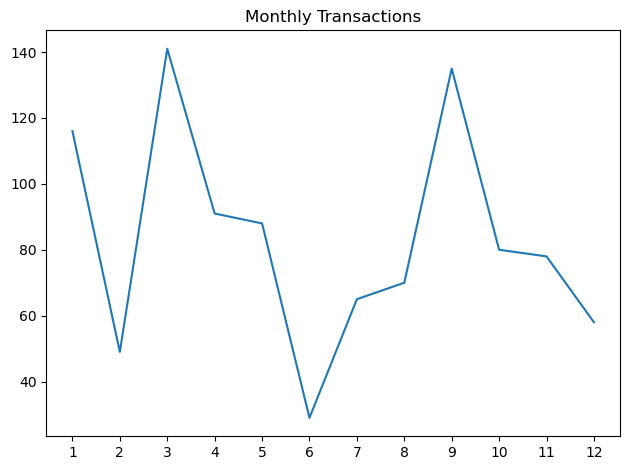

In [63]:
plt.figure()
plt.plot(monthly_tx["Month"].astype(str), monthly_tx["transactions"])
plt.title("Monthly Transactions")
plt.tight_layout()
plt.show()

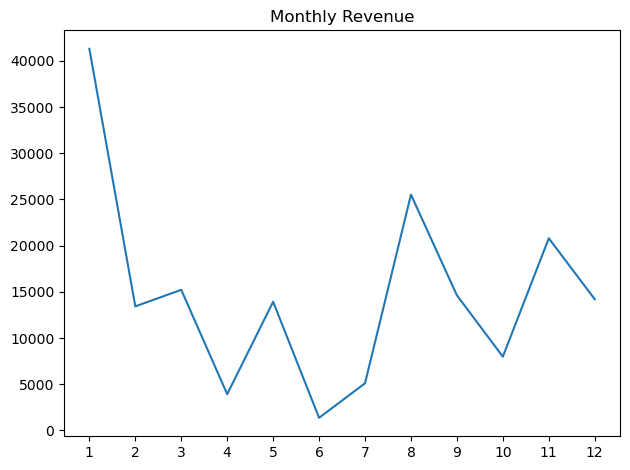

In [64]:
plt.figure()
plt.plot(monthly_rev["Month"].astype(str), monthly_rev["revenue"])
plt.title("Monthly Revenue")
plt.tight_layout()
plt.show()


In [65]:
top_products_qty = (transaction_valid.groupby(["CatalogEntryId","ProductName"])["Quantity"].sum().sort_values(ascending=False).head(5).reset_index())
top_products_rev = (transaction_valid.groupby(["CatalogEntryId","ProductName"])["ExtendedPrice"].sum().sort_values(ascending=False).head(5).reset_index())
print("Top 5 Products by Quantity", top_products_qty)
print("Top 5 Products by Revenue", top_products_rev)

Top 5 Products by Quantity   CatalogEntryId                                        ProductName  Quantity
0           EJ16  D'Addario EJ16 Phosphor Bronze Acoustic Guitar...     340.0
1         EXL110  D'Addario EXL110 Nickel Wound Electric Guitar ...     300.0
2         EXL115  D'Addario EXL115 Nickel Wound Electric Guitar ...     250.0
3           EJ45  D'Addario EJ45 Pro-Arte Nylon Classical Guitar...     222.0
4           EJ17  D'Addario EJ17 Phosphor Bronze Acoustic Guitar...     180.0
Top 5 Products by Revenue   CatalogEntryId                                        ProductName  \
0           DF78                             D'Addario Wooden Stool   
1       SOSETSTD           SoundOff by Evans Full Box Set, Standard   
2       PWAT-6R3  D'Addario Auto-Trim Tuning Machines, 6 In-Line...   
3          RF12G            RealFeel by Evans Practice Pad, 12 Inch   
4          ETB92  50-105 Medium, Long Scale, XL Nylon Tapewound ...   

   ExtendedPrice  
0       17280.00  
1       13600.

In [66]:
# Tính bảng RFM (Recency, Frequency, Monetary)
import datetime

# Ngày tham chiếu là ngày lớn nhất trong dữ liệu + 1
snapshot_date = df_rec['LineItemOrdering'].max() + pd.Timedelta(days=1)

rfm = df_rec.groupby('CustomerId').agg({
    'LineItemOrdering': lambda x: (snapshot_date - x.max()).days,  # Recency
    'OrderStatus': 'count',  # Frequency (số lần mua)
    'ExtendedPrice': 'sum'   # Monetary (tổng chi tiêu)
}).reset_index()

rfm.columns = ['CustomerId', 'Recency', 'Frequency', 'Monetary']
rfm = rfm.sort_values('Recency')
rfm.head(20)

,CustomerId,Recency,Frequency,Monetary
15,50AA1963-AF88-4E60-83D8-0011C970AB93,1,2,2816.78
44,EDAF2E28-CEE7-4060-A077-000B61D1AB32,20,1,139.99
45,F35ED95F-483E-4952-A09F-0007A578F50C,29,2,95.97
27,795F46C7-906F-4462-9494-0002B3D717C5,31,11,934.89
10,443B0C06-857E-4C12-BED3-00026A664FE9,40,5,3477.98
42,E47D78A1-BEA9-48BE-8745-000B79F0B557,46,7,185.20
8,3B516ADC-6C26-45CF-9B60-0007CC5A6578,64,13,62560.00
35,BB0BC59A-C2CF-4D62-A215-000A61D39E9B,92,4,28.97
31,9C96AAE8-7B6A-4291-A623-0009586BB529,92,16,6220.87
36,BCA60604-0F78-45FB-B4F7-001259EC6E18,95,1,2000.00


In [69]:
# Tạo ma trận CSR cho user-item (implicit feedback)
from scipy import sparse
from scipy.sparse import save_npz
import os

# Đảm bảo DATA_DIR là thư mục data trong workspace
DATA_DIR = '/Users/sonde/Documents/Recommender System/data'
if not os.path.exists(DATA_DIR):
    os.makedirs(DATA_DIR)

# Chỉ lấy các giao dịch hợp lệ (ví dụ: đã lọc trạng thái)
tx_valid = transaction_valid.copy()
tx_valid["implicit_score"] = 1.0 + np.log1p(tx_valid["ExtendedPrice"].fillna(0.0)) + 0.2 * tx_valid["Quantity"].fillna(0.0)

agg = (tx_valid.groupby(["CustomerId", "CatalogEntryId"], as_index=False)
       .agg(score=("implicit_score", "sum"),
            qty=("Quantity", "sum"),
            spend=("ExtendedPrice", "sum")))

user_ids = agg["CustomerId"].unique()
item_ids = agg["CatalogEntryId"].unique()
uid2ix = {u: i for i, u in enumerate(user_ids)}
iid2ix = {it: i for i, it in enumerate(item_ids)}
agg["u_idx"] = agg["CustomerId"].map(uid2ix)
agg["i_idx"] = agg["CatalogEntryId"].map(iid2ix)

num_users = len(user_ids)
num_items = len(item_ids)
mat = sparse.csr_matrix((agg["score"].values, (agg["u_idx"].values, agg["i_idx"].values)),
                        shape=(num_users, num_items), dtype=np.float32)

save_npz(os.path.join(DATA_DIR, "user_item_matrix.npz"), mat)
pd.Series(user_ids, name="CustomerId").to_csv(os.path.join(DATA_DIR, "user_index_to_id.csv"), index=False)
pd.Series(item_ids, name="CatalogEntryId").to_csv(os.path.join(DATA_DIR, "item_index_to_id.csv"), index=False)
agg.to_csv(os.path.join(DATA_DIR, "user_item_interactions.csv"), index=False)

# Xem trước ma trận top 10x10
top_users = (agg.groupby("u_idx")["score"].sum().sort_values(ascending=False).head(10).index.tolist())
top_items = (agg.groupby("i_idx")["score"].sum().sort_values(ascending=False).head(10).index.tolist())
preview = (agg[agg["u_idx"].isin(top_users) & agg["i_idx"].isin(top_items)]
           .pivot_table(index="u_idx", columns="i_idx", values="score", fill_value=0.0)
           .reset_index())

preview.head(10)

i_idx,u_idx,0,8,24,95,110,127,147,171,173,274
0,7,0.000000,0.000000,10.387322,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,25,70.994068,66.322498,16.597759,7.962845,22.785817,23.199832,95.710307,80.749811,80.387605,40.377944
2,29,0.000000,0.000000,82.789932,83.339111,33.445404,78.986254,0.000000,0.000000,0.000000,39.476783
3,32,0.000000,0.000000,0.000000,0.000000,4.614868,4.711545,0.000000,0.000000,0.000000,15.218872
